In [1]:
# Подключенине библиотек
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from custom_modules import data_processing as dp
import custom_modules.PipeData as pidf

from matplotlib import ticker
from IPython.display import display
from tensorflow import keras

In [2]:
def draw_map(data_map):
    with plt.style.context('dark_background'):
            fig, ax = plt.subplots()
        
            fig.set_figwidth(18)
            fig.set_figheight(8)
            fig.patch.set_alpha(0.0)
        
            ax.invert_yaxis()
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
            ax.set_title("Предсказанная развернутая карта дефектов", fontsize=25)
            ax.set_xlabel('Номер датчика', fontsize=20)
            ax.set_ylabel('Номер измерения', fontsize=20)
            ax.tick_params(axis='both', labelsize = 20)

            map = ax.pcolormesh(data_map)
            cbar = fig.colorbar(map)
            cbar.ax.tick_params(labelsize=20)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    
    plt.show()

In [3]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/Original data/Run1/run1_WM32_data.csv',
        'data/Original data/Run1/run1_WM32_defects.csv',
        'data/Original data/Run1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/Original data/Run2/run2_WM32_data.csv',
        'data/Original data/Run2/run2_WM32_defects.csv',
        'data/Original data/Run2/run2_WM32_pipe.csv')
}

CROP_SIZE = 8
CROP_STEP = 1
RUN = 2
PATH_TO_MODEL = 'networks/CNN/id=06_in(8x8+8x8)_out(1)_train=0dot000056_test=0dot0682.h5'

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [4]:
# чтение данных
data_cl = pidf.PipeDataCsvWorker(*PATH_TO_DATA[f'run_{RUN}'])

In [5]:
# Загрузка модели
load_model = keras.models.load_model(PATH_TO_MODEL)

In [6]:
def make_pred_fast(model, cl: pidf.PipeDataCsvWorker, crop_size: int, crop_step: int):

    ref_orig_df = cl.get_defects_df()
    or_rows = cl.get_data_df().shape[0]
    or_cols = cl.get_data_df().shape[1]

    cl.extend_dfs_for_prediction(crop_size, crop_step)

    ref_extend_df = cl.get_defects_df()
    ex_rows = cl.get_data_df().shape[0]
    ex_cols = cl.get_data_df().shape[1]
    
    x_data = cl.get_data_df()

    (x_data_time,
    x_data_amp) = dp.reshape_X_df_to_image_like_numpy(x_data, crop_size, crop_step)

    x_data_time = dp.standartize_data(x_data_time)
    x_data_amp = dp.standartize_data(x_data_amp)

    res = model.predict([x_data_time, x_data_amp])
    res = res[:,0]

    extend_arr = np.ones((ex_rows, ex_cols))     
    
    res_it = iter(res) 
    
    for j in range(0,  ex_cols - crop_size + 1, crop_step):
        for i in range(0, ex_rows - crop_size + 1, crop_step):  
            temp_add = next(res_it)
            
            if temp_add >= 0.5:
                extend_arr[i:i+crop_size, j:j+crop_size] += temp_add
            else:
                extend_arr[i:i+crop_size, j:j+crop_size] -= temp_add 
    

    left_up_border = crop_size - 1
    
    orig_arr = extend_arr[left_up_border:, left_up_border:][:or_rows, :or_cols]

    extend_df = pd.DataFrame(data=extend_arr, 
                             columns=cl.get_data_df().columns, 
                             index=cl.get_data_df().index)

    orig_df = pd.DataFrame(data=orig_arr, 
                       columns=cl.get_data_df().columns.tolist()[left_up_border:][:or_cols], 
                       index=cl.get_data_df().index.tolist()[left_up_border:][:or_rows])
    
    return orig_df, extend_df, ref_orig_df, ref_extend_df, orig_arr, extend_arr 

In [7]:
orig_df, extend_df, ref_orig_df, ref_extend_df, orig_arr, extend_arr  = make_pred_fast(load_model, data_cl, CROP_SIZE, CROP_STEP)

||||||||||||||||||
X df reshaping to 4D
Original df size:  (133, 414)
Crop windows height/width:  8
Crop windows step across rows and cols:  1
New X_time shape:  (51282, 8, 8, 32)
New X_amp shape:  (51282, 8, 8, 32)
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before normalization: 44.4
arr_min before normalization: 0.0
arr_max after normalization: 1.0
arr_min after normalization: 0.0
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before normalization: 62.992
arr_min before normalization: -62.482
arr_max after normalization: 1.0
arr_min after normalization: -0.9919037338074677
||||||||||||||||||

1603/1603 [==============================] - 109s 68ms/step


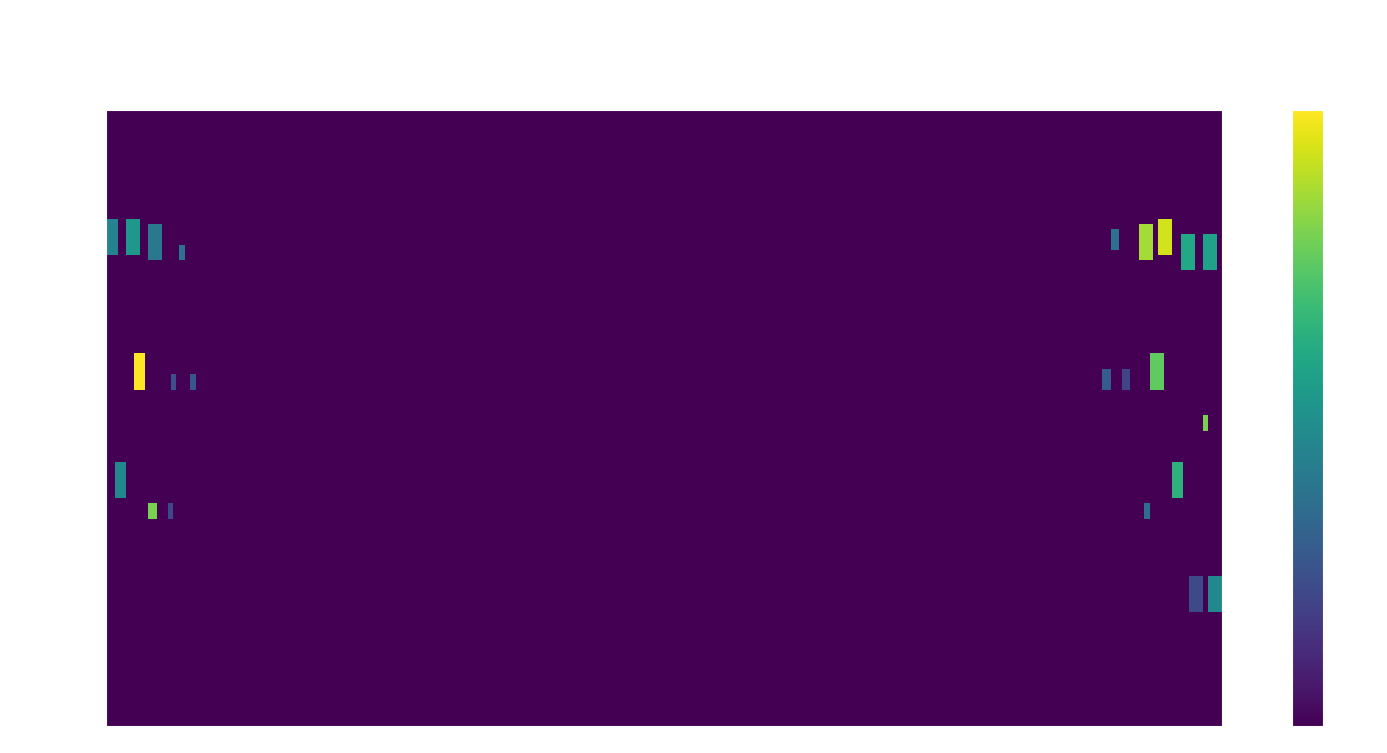

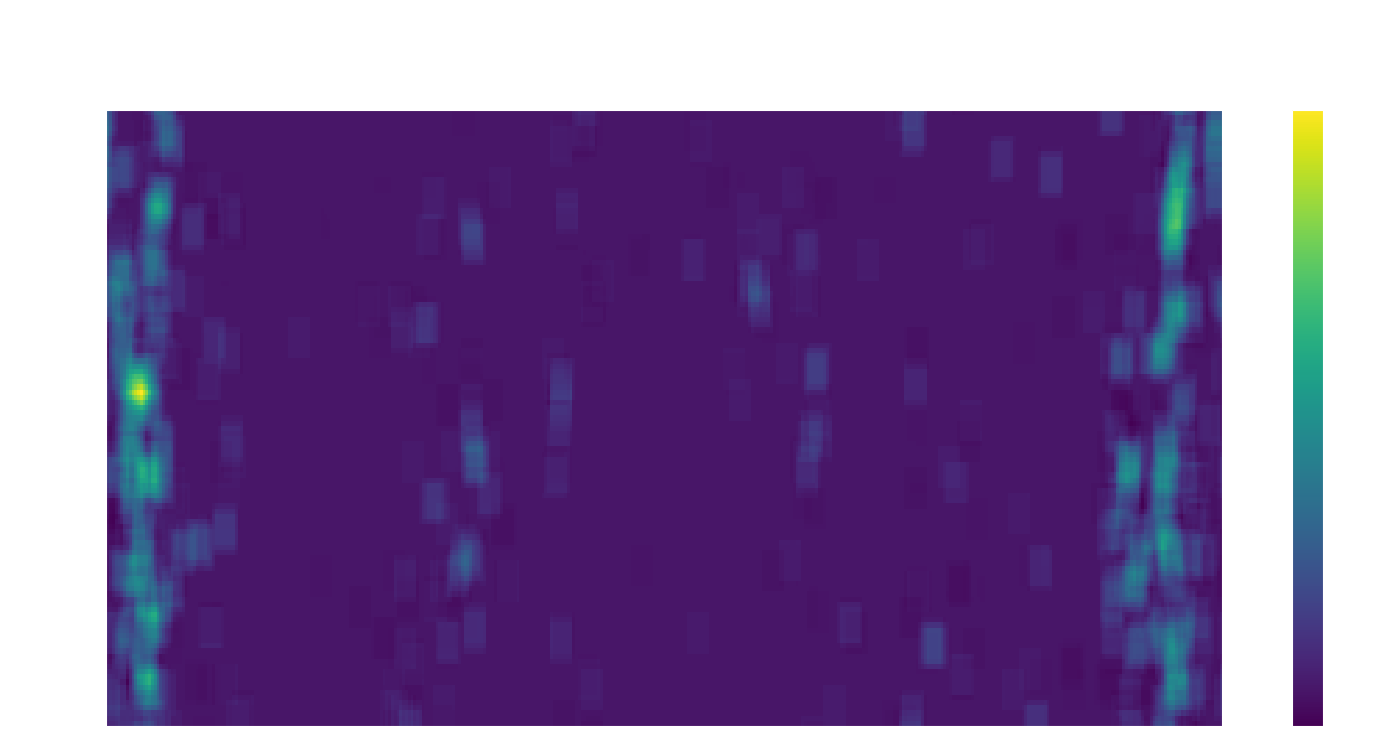

In [8]:
draw_map(ref_orig_df)
draw_map(orig_df)

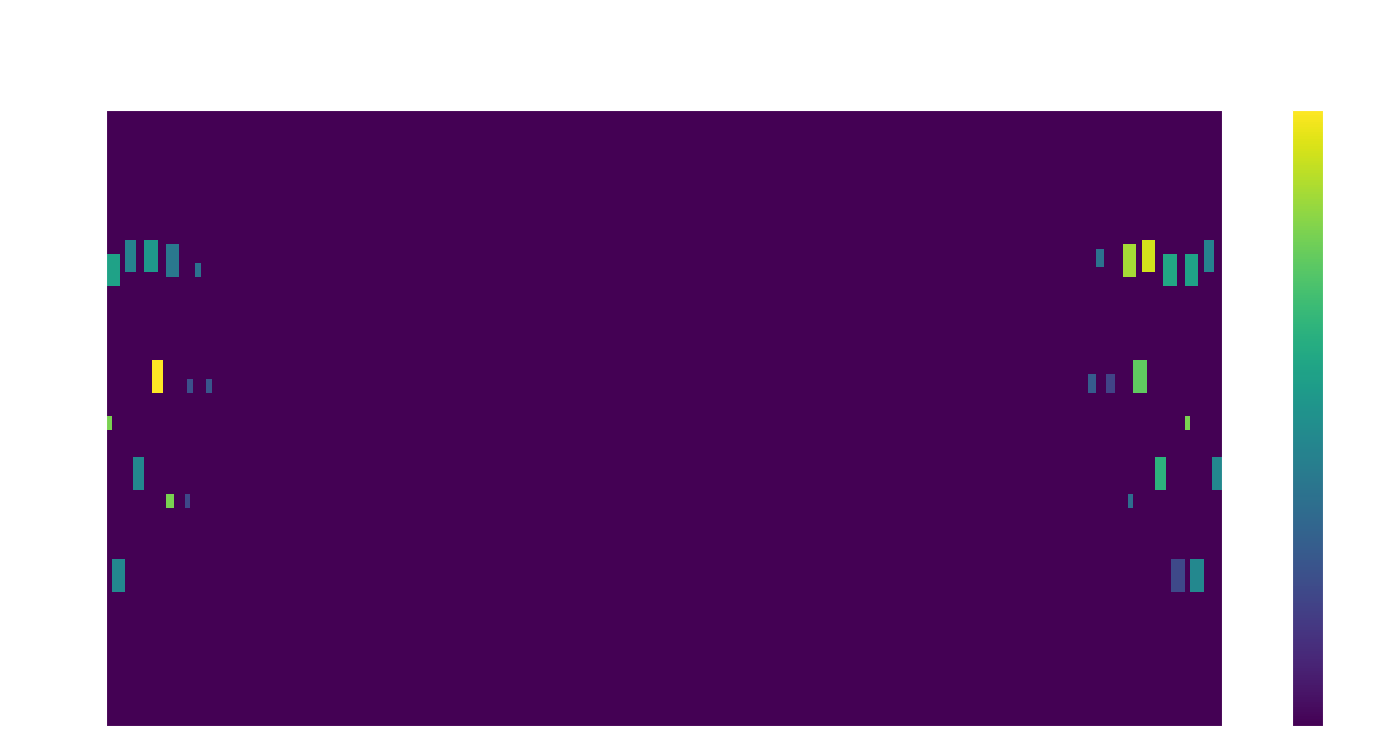

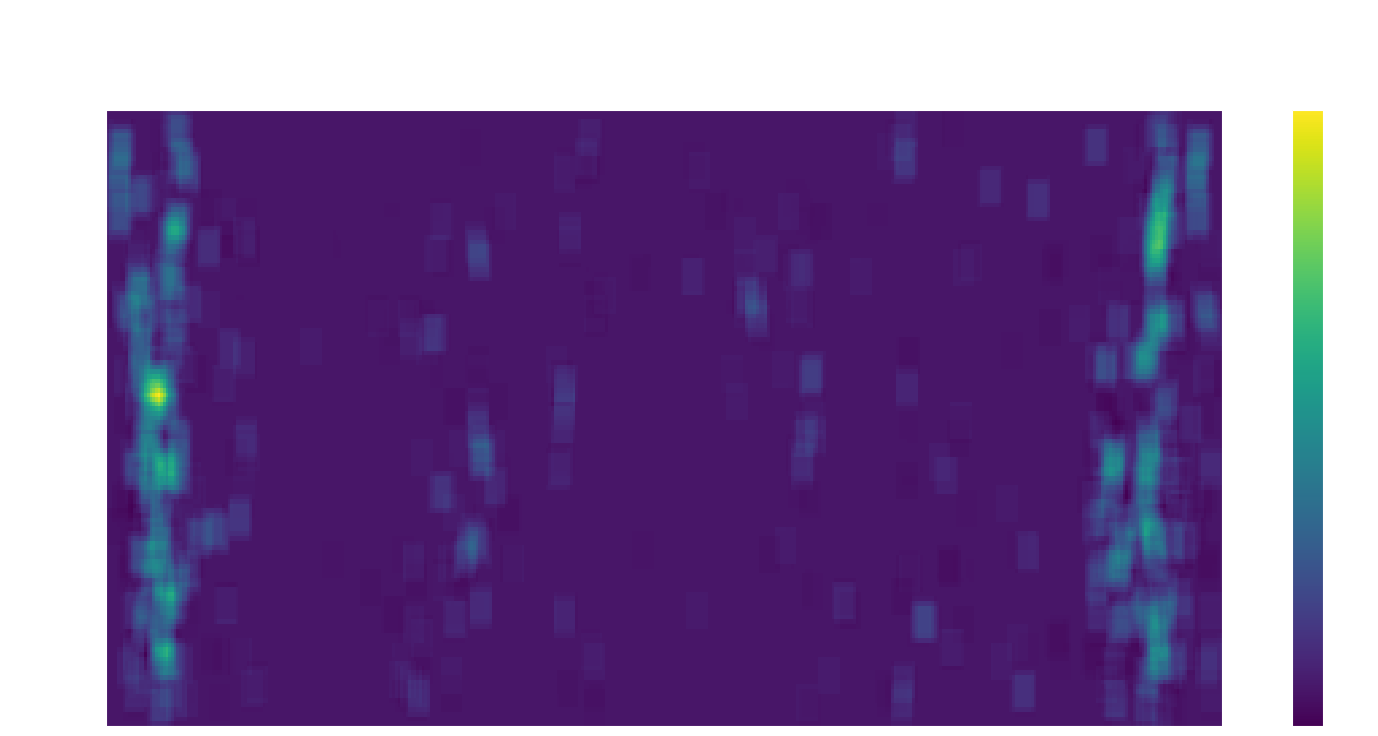

In [9]:
draw_map(ref_extend_df)
draw_map(extend_df)

In [10]:
model_id = re.search(r'(id=)[0-9]+', PATH_TO_MODEL)[0].split('=')[-1]
path = f'data/Drawing data/Run{RUN}/' + \
    f'model_id={model_id}_crop(size={CROP_SIZE},step={CROP_STEP}).xlsx'

with pd.ExcelWriter(path) as writer:  
    orig_df.to_excel(writer, sheet_name='orig_res')
    extend_df.to_excel(writer, sheet_name='extend_res')
    
    ref_orig_df.to_excel(writer, sheet_name='orig_reference')
    ref_extend_df.to_excel(writer, sheet_name='extend_reference')